<a href="https://colab.research.google.com/github/JLGhost/Coursera_Capstone/blob/main/Coursera_Capstone_Project_A_new_restaurant_in_Quito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center><font size = 6>Coursera Capstone Project</font></h1>
<h1 align=center><font size = 5>A new restaurant in Quito: What is the best location of the city?</font></h1>
<h1 align=center><font size = 4>Jorge Luis Vega</font></h1>
<h1 align=center><font size = 4>January 14, 2021</font></h1>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this project we will try to find an optimal location for opening a new restaurant in the different locations of Quito **(North, South or Centre of the city)**.

Quito, the capital of Ecuador, is a city that is characterized by its gastronomy. Most of the citizens know which are the best restaurants in the city and it's due to their ratings and reviews than others can go to these restaurants hoping **good food and a good service**. 

We will use our  data science criteria to find out what is the best part of the city for opening a new restaurant.

## Data <a name="data"></a>

Factors that will influence for opening a new restaurants are:
* The number of restaurants in the three parts of the city
* The amount of ratings
* The amount of reviews

We decided to use a data base of the nighborhoods in Quito to obtain the different restaurants around of them.
Following data sources will be needed to extract / generate the required information:
* Number of restaurants in the city and their location using **Foursquare API**.
* Ratings and reviews of restaurant throughout the city using **Google Maps**.

### Restaurant throughout the city

We use geopy library to get the latitude and longitude values of Quito City. Then, we upload the data base of Quito's neighborhoods for getting thier coordinates and finding restaurans nearby each one.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


We use Foursquare API for getting the restaurants location

In [2]:
# get the coordinates of Quito
address = 'Quito, Ecuador'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Quito are: {}, {}.'.format(latitude, longitude))

#upload the Quito's neighborhoods data base
data_neigh = pd.read_csv('/content/drive/MyDrive/Python/Cursos/Capson Project Data Science/neighborhoods_quito.csv')
data_neigh.head()

The geograpical coordinate of Quito are: -0.2201641, -78.5123274.


,Neighborhood,Latitude,Longitude,Location
0,Centro Histórico,-0.218798,-78.516610,Centre
1,La Tola,-0.224491,-78.512119,Centre
2,El Dorado,-0.214281,-78.500297,Centre
3,San Roque,-0.219040,-78.533655,Centre
4,La Ronda,-0.224086,-78.516581,Centre


Let's visualize the neighborhoods in the Quito's map.
* Neighborhoods in the north are represented by color red
* Neighborhoods in the south are represented by color green
* Neighborhoods in the centre are represented by color blue


In [3]:
# create map of Quito using latitude and longitude values
map_quito = folium.Map(location=[latitude, longitude], zoom_start = 10.5)
# add markers to map
for neighborhood, lat, lng, location in zip(data_neigh['Neighborhood'], data_neigh['Latitude'], data_neigh['Longitude'], data_neigh['Location']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    if location == 'Centre':
      colors = 'blue'
      fill_colors = '#3186cc'
    if location == 'North':
      colors = 'red'
      fill_colors = '#DF4743'
    if location == 'South':
      colors = 'green'
      fill_colors = '#90DA43'
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = colors,
        fill = True,
        fill_color = fill_colors,
        fill_opacity = 0.7,
        parse_html = False).add_to(map_quito)  
    
map_quito

Let's explore the restaurants in each neighborhood.

In [38]:
# Foursquare API credentials and endpoint
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's create a function to get all restaurants in the neighborhoods

In [5]:
def getRestaurants(names, latitudes, longitudes, radius = 500):
  places_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    # return all information for each neighborhood
    for place in results:
      name_category = place['venue']['categories'][0]['name']
      name = place['venue']['name']
      lat = place['venue']['location']['lat']
      lng = place['venue']['location']['lng']
      places_list.append([name_category, name, lat, lng])
  return(places_list)

In [6]:
places_quito = getRestaurants(names = data_neigh['Neighborhood'], 
                              latitudes = data_neigh['Latitude'], 
                              longitudes = data_neigh['Longitude']
                              )

In [39]:
# create a data frame from "places_quito"
nearby_places = pd.DataFrame(places_quito)
nearby_places.columns = ['Category', 'Name', 'Latitude', 'Longitude']
nearby_places.head()
# get the unique categories of the dataframe and keep the places related with food
nearby_places['Category'].unique()
# create a keyword list
food_related = 'Restaurant|Breakfast|Diner|Food|Pizza|BBQ|Fried|BurgerWings'
restaurant_data = nearby_places[nearby_places['Category'].str.contains(food_related)].reset_index(drop = True)
# and erase duplicate information
restaurant_data.drop_duplicates(inplace=True)
restaurant_data.reset_index(drop=True, inplace = True)
restaurant_data.head()

,Category,Name,Latitude,Longitude
0,Breakfast Spot,Café Plaza Grande,-0.219723,-78.512227
1,Cajun / Creole Restaurant,La Colmena,-0.219759,-78.513558
2,Restaurant,San Ignacio Restaurant,-0.221389,-78.513862
3,Fried Chicken Joint,Gus,-0.219331,-78.513041
4,Bed & Breakfast,La Casona De La Ronda,-0.224727,-78.513618


Let's visualize the restaurants in the Quito's map.

In [8]:
# create map of Quito using latitude and longitude values
map_quito = folium.Map(location=[latitude, longitude], zoom_start = 11)

# add markers to map
for lat, lng, category, name in zip(restaurant_data['Latitude'], restaurant_data['Longitude'], restaurant_data['Category'], restaurant_data['Name']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_quito)  
    
map_quito

In [9]:
restaurant_data.count()

Category     190
Name         190
Latitude     190
Longitude    190
dtype: int64

We found 191 restaurants or related around Quito

However, using this Foursquare API "free-account" we can't see the reviews and ratings, so we are going to use data got from Google Maps. Data got from Foursquare will help us to know the amount of restaurants in each part of the city, and data got from Google Maps will help us to know the ratings and reviews.

We upload the data base of Quito's restaurants from Google Maps

In [10]:
#upload the data base
restaurant_datamaps = pd.read_csv('/content/drive/MyDrive/Python/Cursos/Capson Project Data Science/restaurants_quito.csv')
restaurant_datamaps.head()

,Name,Rating,Review,Latitude,Longitude
0,Café Plaza Grande,4.5,8,-0.219723,-78.512227
1,La Colmena,4.2,167,-0.219759,-78.513558
2,San Ignacio Restaurant,4.4,387,-0.221389,-78.513862
3,La Casona De La Ronda,4.6,174,-0.224727,-78.513618
4,Casa Los Geranios,4.5,390,-0.225019,-78.513576


In [11]:
restaurant_datamaps.count()

Name         191
Rating       191
Review       191
Latitude     191
Longitude    191
dtype: int64

Now we can merge these both information to relate it.

In [12]:
data_quito = restaurant_datamaps.copy()
data_quito['Category'] = restaurant_data['Category'].copy()
data_quito.head()

,Name,Rating,Review,Latitude,Longitude,Category
0,Café Plaza Grande,4.5,8,-0.219723,-78.512227,Breakfast Spot
1,La Colmena,4.2,167,-0.219759,-78.513558,Cajun / Creole Restaurant
2,San Ignacio Restaurant,4.4,387,-0.221389,-78.513862,Restaurant
3,La Casona De La Ronda,4.6,174,-0.224727,-78.513618,Fried Chicken Joint
4,Casa Los Geranios,4.5,390,-0.225019,-78.513576,Bed & Breakfast


In [13]:
data_quito.count()

Name         191
Rating       191
Review       191
Latitude     191
Longitude    191
Category     190
dtype: int64

In [14]:
restaurant_data.head()

,Category,Name,Latitude,Longitude
0,Breakfast Spot,Café Plaza Grande,-0.219723,-78.512227
1,Cajun / Creole Restaurant,La Colmena,-0.219759,-78.513558
2,Restaurant,San Ignacio Restaurant,-0.221389,-78.513862
3,Fried Chicken Joint,Gus,-0.219331,-78.513041
4,Bed & Breakfast,La Casona De La Ronda,-0.224727,-78.513618


Now we have the data for working with

## Methodology <a name="methodology"></a>

In this project we collected information of restaurants in differets neighborhoods located in the three parts of the city (north, south and centre). We will limit our analysis to find the best part of the city, and then we will find out what neighborhoods are more suitable for openening a new restaurant.

In the first step we have to relate the data base of restaurants **(restaurants location)** with each part of the city, using the data base of the neighborhoods. 

Second step in our analysis will be to find out the **relation between the ratings and the reviews.**  

In third and final step we will focus on **most promising areas with better ratings and reviews.** We will present on the map this locations and the neighborhoods more suitables for opening a new restaurants.  

## Analysis <a name="analysis"></a>

Let's find to what neighborhoods correspond each restaurant

In [15]:
data_quito
data_neigh #Location

location_data = []
i = 0
for res_lat, res_lng in zip(data_quito['Latitude'],data_quito['Longitude']):
  index_ = []
  for neig_lat, neig_lng in zip(data_neigh['Latitude'],data_neigh['Longitude']):
    distance = np.sqrt((neig_lat - res_lat)**2 + (neig_lng - res_lng)**2)
    index_.append(distance)
  index_location = index_.index(min(index_))

  location_data.append([data_quito.iloc[i,0], data_quito.iloc[i,1], 
                        data_quito.iloc[i,2], data_quito.iloc[i,3],
                        data_quito.iloc[i,4], data_quito.iloc[i,5],
                        data_neigh.iloc[index_location,3]])
  i = i + 1

In [16]:
location_data = pd.DataFrame(location_data)
location_data.columns = ['Name', 'Rating', 'Review', 'Latitude', 'Longitude', 'Category', 'Location']
location_data.head()

,Name,Rating,Review,Latitude,Longitude,Category,Location
0,Café Plaza Grande,4.5,8,-0.219723,-78.512227,Breakfast Spot,Centre
1,La Colmena,4.2,167,-0.219759,-78.513558,Cajun / Creole Restaurant,Centre
2,San Ignacio Restaurant,4.4,387,-0.221389,-78.513862,Restaurant,Centre
3,La Casona De La Ronda,4.6,174,-0.224727,-78.513618,Fried Chicken Joint,Centre
4,Casa Los Geranios,4.5,390,-0.225019,-78.513576,Bed & Breakfast,Centre


Let's visualize the restaurants in the neighborhoods in the Quito's map.
* Restaurants in the north are represented by color red
* Restaurants in the south are represented by color green
* Restaurants in the centre are represented by color blue

In [17]:
# create map of Quito using latitude and longitude values
map_quito = folium.Map(location=[latitude, longitude], zoom_start = 12)
# add markers to map
for name, lat, lng, location, rating in zip(location_data['Name'], location_data['Latitude'], location_data['Longitude'], location_data['Location'], location_data['Rating']):
    label = '{}, {}'.format(name, rating)
    label = folium.Popup(label, parse_html=True)
    if location == 'Centre':
      colors = 'blue'
      fill_colors = '#3186cc'
    if location == 'North':
      colors = 'red'
      fill_colors = '#DF4743'
    if location == 'South':
      colors = 'green'
      fill_colors = '#90DA43'
    folium.CircleMarker(
        [lat, lng],
        radius = 4,
        popup = label,
        color = colors,
        fill = True,
        fill_color = fill_colors,
        fill_opacity = 0.7,
        parse_html = False).add_to(map_quito)  
    
map_quito

Let's see how many restaurants are in each neighborhood

Location
Centre     32
North     130
South      29
Name: Total, dtype: int64


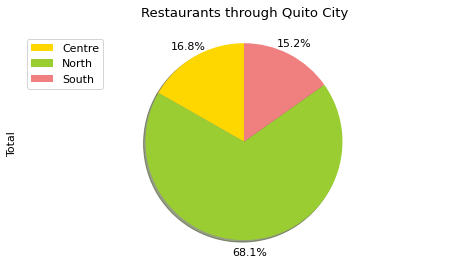

In [18]:
plt.rcParams.update({'font.size': 11})

df_restaurants = location_data.groupby('Location', axis=0).count()
df_restaurants['Total'] = df_restaurants['Name']
print(df_restaurants['Total'])
colors_list = ['gold', 'yellowgreen', 'lightcoral']
explode_list = [0, 0, 0] 


df_restaurants['Total'].plot(kind = 'pie',
                            figsize = (8, 4),
                            autopct = '%1.1f%%', 
                            startangle = 90,    
                            shadow = True,       
                            labels = None,         
                            pctdistance = 1.12,    
                            colors = colors_list,  
                            explode = explode_list,
                            )

# scale the title up by 12% to match pctdistance
plt.title('Restaurants through Quito City', y = 1.05) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_restaurants.index, loc='upper left') 

plt.show()

We can realize that in the North of the city exist more restaurants than the other parts. 

Let's create a box plot of each part of the city based on ratings and reviews

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


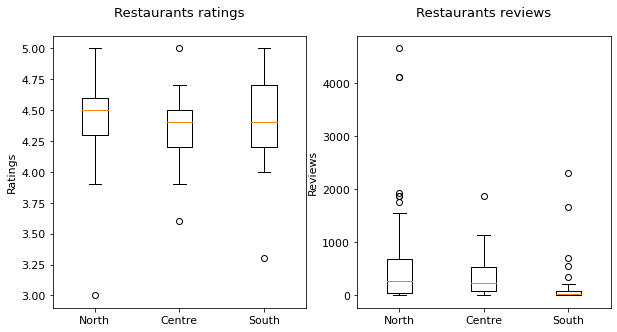

In [19]:
quito_north = location_data[location_data['Location']  == 'North']
quito_centre = location_data[location_data['Location'] == 'Centre']
quito_south = location_data[location_data['Location']  == 'South']

plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(1,2,figsize=(10, 5))
plt.figsize=(20, 6)
plt.sca(axes[0])

ratings = [np.array(quito_north['Rating'],  dtype = 'float'),
           np.array(quito_centre['Rating'], dtype = 'float'),
           np.array(quito_south['Rating'],  dtype = 'float')
           ]
reviews = [np.array(quito_north['Review'],  dtype = 'float'),
           np.array(quito_centre['Review'], dtype = 'float'),
           np.array(quito_south['Review'],  dtype = 'float')
           ]
plt.boxplot(ratings)
plt.title('Restaurants ratings', y = 1.05)
plt.ylabel('Ratings')
plt.xticks([1, 2, 3], ['North', 'Centre', 'South'])

plt.sca(axes[1])
plt.boxplot(reviews)
plt.title('Restaurants reviews', y = 1.05)
plt.ylabel('Reviews')
plt.xticks([1, 2, 3], ['North', 'Centre', 'South'])

plt.show()

In [20]:
quito_south.describe()

,Rating,Review,Latitude,Longitude
count,29.000000,29.000000,29.000000,29.000000
mean,4.427586,224.275862,-0.267292,-78.536372
std,0.399908,523.593142,0.025319,0.016641
min,3.300000,1.000000,-0.320340,-78.558113
25%,4.200000,11.000000,-0.274300,-78.551498
50%,4.400000,21.000000,-0.257856,-78.541873
75%,4.700000,91.000000,-0.249400,-78.522538
max,5.000000,2307.000000,-0.237657,-78.507207


In [21]:
quito_centre.describe()

,Rating,Review,Latitude,Longitude
count,32.000000,32.000000,32.000000,32.000000
mean,4.362500,358.218750,-0.218569,-78.509149
std,0.257469,401.360889,0.005702,0.006734
min,3.600000,2.000000,-0.225498,-78.514683
25%,4.200000,75.250000,-0.221586,-78.513337
50%,4.400000,236.500000,-0.219751,-78.511690
75%,4.500000,539.000000,-0.218602,-78.509120
max,5.000000,1877.000000,-0.205777,-78.490847


In [22]:
quito_north.describe()

,Rating,Review,Latitude,Longitude
count,130.000000,130.000000,130.000000,130.000000
mean,4.446923,518.376923,-0.177624,-78.485337
std,0.251565,738.556074,0.025518,0.006531
min,3.000000,1.000000,-0.205633,-78.509700
25%,4.300000,53.000000,-0.197986,-78.488989
50%,4.500000,266.500000,-0.184510,-78.483855
75%,4.600000,682.500000,-0.161907,-78.481007
max,5.000000,4647.000000,-0.122074,-78.471866


Now we can see that the north of the city has the best mean on ratings and reviews. We can conclude that this is the best part of the city for opening a new restaurant. However, we need to find the best part of the north of the city

Let's focus on the north of the city

In [23]:
# create map of Quito North using latitude and longitude values
latitude,longitude = -0.166111, 	-78.488611
map_quito = folium.Map(location=[latitude, longitude], zoom_start = 12)
# add markers to map
for name, lat, lng, location, rating in zip(quito_north['Name'], quito_north['Latitude'], quito_north['Longitude'], quito_north['Location'], location_data['Rating']):
    label = '{}, {}'.format(name, rating)
    label = folium.Popup(label, parse_html=True)
    if location == 'Centre':
      colors = 'blue'
      fill_colors = '#3186cc'
    if location == 'North':
      colors = 'red'
      fill_colors = '#DF4743'
    if location == 'South':
      colors = 'green'
      fill_colors = '#90DA43'
    folium.CircleMarker(
        [lat, lng],
        radius = 4,
        popup = label,
        color = colors,
        fill = True,
        fill_color = fill_colors,
        fill_opacity = 0.7,
        parse_html = False).add_to(map_quito)  
    
map_quito

Cluster the north restaurants

In [24]:
quito_north.reset_index(drop=True, inplace = True)
quito_grouped_clustering = quito_north[['Rating','Review']]

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(quito_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

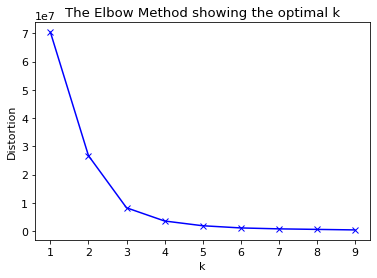

In [25]:
plt.figure(figsize=(6,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 3 which is optimal for this case. Now we can run a K-Means using as number of clusters the number 3. 

In [26]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(quito_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 0, 0, 0, 0, 2, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
quito_north.insert(0, 'Cluster Labels', kmeans.labels_)

Finally, let's visualize the resulting clusters

In [28]:
# create map
latitude,longitude = -0.166111, 	-78.488611
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(quito_north['Latitude'], quito_north['Longitude'], quito_north['Name'], quito_north['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Clustering #1

In [29]:
cluster_1 = quito_north[quito_north['Cluster Labels'] == 0]
cluster_1.describe()

,Cluster Labels,Rating,Review,Latitude,Longitude
count,90.0,90.000000,90.000000,90.000000,90.000000
mean,0.0,4.431111,184.966667,-0.175211,-78.485429
std,0.0,0.285470,181.275472,0.027691,0.006435
min,0.0,3.000000,1.000000,-0.205633,-78.509700
25%,0.0,4.300000,35.500000,-0.198018,-78.488608
50%,0.0,4.500000,124.000000,-0.184580,-78.485582
75%,0.0,4.600000,297.000000,-0.155141,-78.481252
max,0.0,5.000000,568.000000,-0.122074,-78.471866


Clustering #2

In [30]:
cluster_2 = quito_north[quito_north['Cluster Labels'] == 1]
cluster_2.describe()

,Cluster Labels,Rating,Review,Latitude,Longitude
count,3.0,3.00,3.000000,3.000000,3.000000
mean,1.0,4.30,4289.000000,-0.191509,-78.493472
std,0.0,0.10,310.116107,0.018126,0.008030
min,1.0,4.20,4103.000000,-0.205336,-78.502605
25%,1.0,4.25,4110.000000,-0.201770,-78.496447
50%,1.0,4.30,4117.000000,-0.198204,-78.490289
75%,1.0,4.35,4382.000000,-0.184596,-78.488905
max,1.0,4.40,4647.000000,-0.170988,-78.487522


Clustering #3

In [31]:
cluster_3 = quito_north[quito_north['Cluster Labels'] == 2]
cluster_3.describe()

,Cluster Labels,Rating,Review,Latitude,Longitude
count,37.0,37.000000,37.000000,37.000000,37.000000
mean,2.0,4.497297,1023.648649,-0.182368,-78.484452
std,0.0,0.140409,378.026543,0.019121,0.006369
min,2.0,4.200000,622.000000,-0.204338,-78.499353
25%,2.0,4.400000,696.000000,-0.196785,-78.489271
50%,2.0,4.500000,944.000000,-0.183440,-78.482402
75%,2.0,4.600000,1200.000000,-0.172230,-78.480762
max,2.0,4.700000,1930.000000,-0.123090,-78.475237


In [32]:
des_clus1 = [cluster_1.describe().loc['count','Cluster Labels'],
             cluster_1.describe().loc['mean','Rating'],
             cluster_1.describe().loc['mean','Review']
             ]
des_clus2 = [cluster_2.describe().loc['count','Cluster Labels'],
             cluster_2.describe().loc['mean','Rating'],
             cluster_2.describe().loc['mean','Review']
             ]
des_clus3 = [cluster_3.describe().loc['count','Cluster Labels'],
             cluster_3.describe().loc['mean','Rating'],
             cluster_3.describe().loc['mean','Review']
             ]

In [33]:
cluster_total = pd.DataFrame([des_clus1, des_clus2, des_clus3])

cluster_total.columns = ['Number of restaurants','Mean Rating','Mean Review']
cluster_total['Clusters'] = ['Cluster 1','Cluster 2','Cluster 3']
cluster_total

,Number of restaurants,Mean Rating,Mean Review,Clusters
0,90.0,4.431111,184.966667,Cluster 1
1,3.0,4.300000,4289.000000,Cluster 2
2,37.0,4.497297,1023.648649,Cluster 3


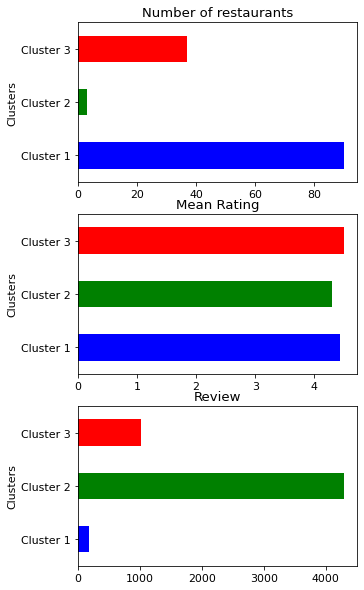

In [34]:

fig, axes = plt.subplots(3,1,figsize=(5, 10))
cluster_total.plot.barh(x='Clusters', 
                        y = 'Number of restaurants',
                        color={'red','blue','green'}, 
                        legend = None,
                        title='Number of restaurants',
                        ax = axes[0])
cluster_total.plot.barh(x='Clusters', 
                        y = 'Mean Rating',
                        color={'red','blue','green'}, 
                        legend = None,
                        title='Mean Rating',
                        ax = axes[1])
cluster_total.plot.barh(x='Clusters', 
                        y = 'Mean Review',
                        color={'red','blue','green'}, 
                        legend = None,
                        title='Review',
                        ax = axes[2])

We can notice these results:
* Cluster 1 does not have enough reviews despite of having a good number of ratings and restaurants. 
* Cluster 2 does not have enough restaurants despite of having a good number of ratings and reviews. 
* Cluster 3 is a middel point between Cluster 1 and Cluster 2 because it has a good amount of restaurants and reviews,  and the best Mean Rating
Thus, Cluster 3 is the best option. Now we have to rank the neighborhoohs where we can open a new restaurans based on this cluster



In [35]:
cluster1_data = []
i = 0
for res_lat, res_lng in zip(cluster_1['Latitude'],cluster_1['Longitude']):
  indexc_ = []
  for neig_lat, neig_lng in zip(data_neigh['Latitude'],data_neigh['Longitude']):
    distance = np.sqrt((neig_lat - res_lat)**2 + (neig_lng - res_lng)**2)
    indexc_.append(distance)
  indexc_location = indexc_.index(min(indexc_))

  cluster1_data.append([data_quito.iloc[i,0], data_quito.iloc[i,1], 
                        data_quito.iloc[i,2],data_neigh.iloc[indexc_location,0]])
  i = i + 1

In [36]:
cluster1_data = pd.DataFrame(cluster1_data)
cluster1_data.columns = ['Name','Rating','Review','Neighborhood']
cluster1_des = cluster1_data.groupby('Neighborhood', axis = 0).describe()

In [37]:
cluster1_des.iloc[0,0] #Number of restaurants
cluster1_des.iloc[0,1] #Mean Rating
cluster1_des.iloc[0,9] #Mean Review

cluster_analysis = []
for idx in range(0,len(cluster1_des.index)):
  cluster_analysis.append([cluster1_des.iloc[idx,0],
                          cluster1_des.iloc[idx,1],
                          cluster1_des.iloc[idx,9]]
                          )
cluster_analysis = pd.DataFrame(cluster_analysis)
cluster_analysis.columns = ['Number of restaurants', 'Mean Rating', 'Mean Review']
cluster_analysis.index = cluster1_des.index.copy()
cluster_analysis.sort_values(by=['Mean Review'], ascending=False).head(10)

,Number of restaurants,Mean Rating,Mean Review
Neighborhood,,,
Quito Norte,8.0,4.487500,818.000000
Rumiñahui,5.0,4.620000,727.400000
Bellavista,14.0,4.421429,726.285714
Guápulo,20.0,4.435000,718.800000
Iñaquito,5.0,4.400000,581.400000
Quito Tennis,1.0,4.500000,568.000000
El Inca,8.0,4.425000,545.000000
Kennedy,3.0,4.566667,464.666667
El Batán,2.0,4.400000,349.000000


Finally, we can rank the top 10 best neighborhoods in the north of Quito that would be good option for opening a new restaurant.

## Results and Discussion <a name="results"></a>

Our analysis shows that there are a large number of restaurants throughout Quito, however the classification to find a suitable place in the three parts of the city (north, south and center) were made taking into account the ratings and reviews made by different people.

It was observed that the most desirable area to open a restaurant is the north of the city, since it has a balance between the number of restaurants, ratings and reviews.

On the other hand, a total of 13 neighborhoods were found in the north of the city, which are a good option to open a new restaurant.

## Conclusion <a name="conclusion"></a>

As proposed at the beginning of this project, the different restaurants throughout the city of Quito were examined. Classifying each of these restaurants based on a database of the neighborhoods of Quito. In this way, the restaurants were grouped by sectors (north, south and center) facilitating the analysis. Through the graphs of pie and box plots, it was concluded that the north of the city is the most desirable area to open a new restaurant. However, by using K-means, I can get more in-depth. Resulting in the different neighborhoods where we can open restaurants based on the ratings and reviews.